In [3]:
import itertools
import numpy as np
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_curve
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')




/Users/xiaoyisun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
seed = 999

Load the data

In [5]:
loan = pd.read_csv('loan_table.csv',index_col = 'loan_id')
loan.rename(columns = {'loan_purpose':'purpose',
                      'loan_granted':'granted',
                      'loan_repaid':'repaid'},inplace = True)
loan.date = pd.to_datetime(loan.date)
borrower = pd.read_csv('borrower_table.csv',index_col = 'loan_id')
borrower.rename(columns = {'is_first_loan':'is_first',
                         'fully_repaid_previous_loans':'repay_prev',
                         'currently_repaying_other_loans':'paying_others',
                         'total_credit_card_limit':'credit_limit',
                         'avg_percentage_credit_card_limit_used_last_year':'credit_used',
                         'saving_amount':'saving',
                         'checking_amount':'checking',
                         'yearly_salary':'salary',
                         'dependent_number':'n_depends'},inplace=True)
loan = loan.join(borrower)
loan.head(5)

,purpose,date,granted,repaid,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends
loan_id,,,,,,,,,,,,,,,
19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [6]:
def cal_profit_should_grant(row):
    profit = 0
    should_grant = 0
    
    grant = row['granted']
    repaid = row['repaid']
    
    if not grant:
        shoud_grant = 0
        profit = 0
    else:
        assert pd.notnull(repaid)
        profit = 1 if repaid == 1 else -1
        should_grant = 1 if repaid == 1 else 0
    return pd.Series({'profit':profit,'should_grant':should_grant})


In [7]:
profits = loan.apply(cal_profit_should_grant,axis = 1)
profits.head(5)

,profit,should_grant
loan_id,,
19454,0,0
496811,0,0
929493,0,0
580653,1,1
172419,-1,0


In [8]:
loan = loan.join(profits)
loan.head(5)

,purpose,date,granted,repaid,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends,profit,should_grant
loan_id,,,,,,,,,,,,,,,,,
19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7,0,0
496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5,0,0
929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4,0,0
580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,1,1
172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4,-1,0


Dealing previous loan history
there is some redundacy between 'is_first', 'repay_prev' and 'paying_other' features. if 'is_first'==1, then 'repay_prev' and 'paying_others' are both NaN for sure.

since I am going to use tree model, which is good at dealing with 'categorical feature', so I will treat the tree features like below:

set 'NaN' in 'reay_prev' and 'paying_others' as -1, which indicates the brower is asking for loan the first time
discard 'is_first' feature, since its information has already been included in '-1' in 'repay_prev' and 'paying_others'
in other words, I treat 'repay_others' and 'paying_others' as categorical feature, and just use ordinary Ordinal Encoding other than more-often used One-Hot-Encoding. why? because tree model looks for cutoff in numeric feature other than calculating the distance , and there is only 3 unique values in the feature (-1,0,1), which is very easy to find cutoff to distinguish each category.

In [9]:
#loan.repay_prev = loan.repay_prev.fillna(-1)
#loan.paying_others = loan.paying_others.fillna(-1)
# or just use: 
loan.fillna({'repay_prev':-1,'paying_others':-1},inplace= True)
#del loan['is_first']
loan.head(5)


,purpose,date,granted,repaid,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends,profit,should_grant
loan_id,,,,,,,,,,,,,,,,,
19454,investment,2012-03-15,0,NaN,1,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7,0,0
496811,investment,2012-01-17,0,NaN,1,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5,0,0
929493,other,2012-02-09,0,NaN,1,-1.0,-1.0,0,NaN,660,3232,1,26500,60,4,0,0
580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,1,1
172419,business,2012-05-21,1,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,-1,0


Check the relation between employe status and salary

In [10]:
loan.loc[loan.is_employed == 0,'salary'].value_counts()

0    34508
Name: salary, dtype: int64

In [11]:
loan.loc[loan.salary == 0,'is_employed'].value_counts()

0    34508
1       13
Name: is_employed, dtype: int64

from above result, we can know that:

all unemployed has 0 salary
most of the brower who doesn't have salary are unemployed
so there is redundancy between 'is_employed' and 'salary ==0 or not'. more features, more easier to get over-fitting. so I keep 'salary' and decide to drop 'is_employed'

In [12]:
del loan['is_employed']

In [13]:
loan.head(5)

,purpose,date,granted,repaid,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,salary,age,n_depends,profit,should_grant
loan_id,,,,,,,,,,,,,,,,
19454,investment,2012-03-15,0,NaN,1,-1.0,-1.0,8600,0.79,1491,6285,45200,42,7,0,0
496811,investment,2012-01-17,0,NaN,1,-1.0,-1.0,5300,0.52,141,5793,0,42,5,0,0
929493,other,2012-02-09,0,NaN,1,-1.0,-1.0,0,NaN,660,3232,26500,60,4,0,0
580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,15800,58,4,1,1
172419,business,2012-05-21,1,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,34800,31,4,-1,0


In [14]:
loan.purpose.value_counts()

home               24314
business           21707
investment         21484
emergency_funds    18091
other              15504
Name: purpose, dtype: int64

In [16]:
loan = pd.get_dummies(loan)
loan.head(5)

,date,granted,repaid,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,salary,age,n_depends,profit,should_grant,purpose_business,purpose_emergency_funds,purpose_home,purpose_investment,purpose_other
loan_id,,,,,,,,,,,,,,,,,,,,
19454,2012-03-15,0,NaN,1,-1.0,-1.0,8600,0.79,1491,6285,45200,42,7,0,0,0,0,0,1,0
496811,2012-01-17,0,NaN,1,-1.0,-1.0,5300,0.52,141,5793,0,42,5,0,0,0,0,0,1,0
929493,2012-02-09,0,NaN,1,-1.0,-1.0,0,NaN,660,3232,26500,60,4,0,0,0,0,0,0,1
580653,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,15800,58,4,1,1,0,0,0,0,1
172419,2012-05-21,1,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,34800,31,4,-1,0,1,0,0,0,0


In [17]:
loan.to_csv('cleaned_loan.csv',index_label = 'loan_id')
X = loan.copy()

In [18]:
y =X.loc[:,'should_grant']
feature_names = ['repay_prev', 'paying_others', 'credit_limit', 'credit_used',
                 'saving', 'checking', 'salary', 'age', 'n_depends', 
                 'purpose_business','purpose_emergency', 'purpose_home', 'purpose_investment']
X = X.loc[:,feature_names]
y.value_counts(normalize=True)

/Users/xiaoyisun/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


0    0.696281
1    0.303719
Name: should_grant, dtype: float64


positive class 'should_grant=1' consists of about 30% of all examples, there is some imbalance in the dataset. so

we should use AUC other than accuracy when learning the model, and
we need to choose a better 'probability cutoff' instead of using the default 0.5
split the whole dataset into Training, Validation, Test three parts, and build DMatrix which will be used in xgboost

In [19]:

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size = 0.3,random_state = seed)
Xtrain,Xvalid,Ytrain, Yvalid = train_test_split(Xtrain,Ytrain,test_size = 0.3,random_state = seed) 

,date,granted,repaid,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,salary,age,n_depends,profit,should_grant,purpose_business,purpose_emergency_funds,purpose_home,purpose_investment,purpose_other
loan_id,,,,,,,,,,,,,,,,,,,,
19454,2012-03-15,0,NaN,1,-1.0,-1.0,8600,0.79,1491,6285,45200,42,7,0,0,0,0,0,1,0
496811,2012-01-17,0,NaN,1,-1.0,-1.0,5300,0.52,141,5793,0,42,5,0,0,0,0,0,1,0
929493,2012-02-09,0,NaN,1,-1.0,-1.0,0,NaN,660,3232,26500,60,4,0,0,0,0,0,0,1
580653,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,15800,58,4,1,1,0,0,0,0,1
172419,2012-05-21,1,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,34800,31,4,-1,0,1,0,0,0,0


In [20]:
train_matrix = xgb.DMatrix(Xtrain,Ytrain)
valid_matrix = xgb.DMatrix(Xvalid,Yvalid)
test_matrix = xgb.DMatrix(Xtest,Ytest)

In [21]:
def train(params):
    params['silent'] = 1
    params['objective'] = 'binary:logistic'  # output probabilities
    params['eval_metric'] = 'auc'

    num_rounds = params["num_rounds"]
    early_stopping_rounds = params["early_stop_rounds"]

    # early stop will check on the last dataset
    watchlist = [(train_matrix, 'train'), (valid_matrix, 'validate')]
    bst = xgb.train(params, train_matrix, num_rounds, watchlist, early_stopping_rounds=early_stopping_rounds)

    print ("parameters: {}".format(params))
    print ("best {}: {:.2f}".format(params["eval_metric"], bst.best_score))
    print ("best #trees: %d" % (bst.best_ntree_limit))

    return bst

In [22]:
params = {}
params['num_rounds'] = 300
params["early_stop_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

model = train(params)

[0]	train-auc:0.819126	validate-auc:0.812065
Multiple eval metrics have been passed: 'validate-auc' will be used for early stopping.

Will train until validate-auc hasn't improved in 30 rounds.
[1]	train-auc:0.88899	validate-auc:0.883675
[2]	train-auc:0.891912	validate-auc:0.886705
[3]	train-auc:0.894149	validate-auc:0.887668
[4]	train-auc:0.891771	validate-auc:0.884324
[5]	train-auc:0.896428	validate-auc:0.889924
[6]	train-auc:0.895386	validate-auc:0.888412
[7]	train-auc:0.897695	validate-auc:0.890655
[8]	train-auc:0.89867	validate-auc:0.892152
[9]	train-auc:0.899358	validate-auc:0.892695
[10]	train-auc:0.900129	validate-auc:0.893251
[11]	train-auc:0.900708	validate-auc:0.893038
[12]	train-auc:0.900778	validate-auc:0.892885
[13]	train-auc:0.901734	validate-auc:0.893726
[14]	train-auc:0.902107	validate-auc:0.893977
[15]	train-auc:0.902457	validate-auc:0.894245
[16]	train-auc:0.902556	validate-auc:0.894289
[17]	train-auc:0.902984	validate-auc:0.894397
[18]	train-auc:0.903677	validate-au

In [23]:
n_trees = model.best_ntree_limit
n_trees

109

Choose best probablity cutoff 

Find best 'probability cutoff' on validation set's ROC curve in this section

In [24]:
yvalid_true = valid_matrix.get_label()
yvalid_predict_probs = model.predict(valid_matrix,ntree_limit = n_trees)

fpr,tpr,thresholds = roc_curve(yvalid_true,yvalid_predict_probs)

In [25]:
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

In [26]:
def cal_profits(repaids,probas,threhold):
    total_profit = 0
    for repaid,proba in itertools.zip_longest(repaids,probas):
        if proba > threhold:
            total_profit += 1 if repaid == 1 else -1
    return total_profit


In [27]:
loan_valid = loan.loc[Yvalid.index,:]
loan_valid.head(5)
valid_profits = [cal_profits(loan_valid.repaid,yvalid_predict_probs,threhold) for threhold in roc.Threshold]

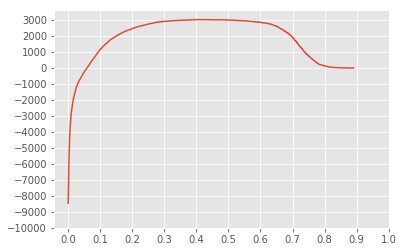

In [28]:
plt.plot(roc.Threshold,valid_profits)
plt.yticks(range(-10000,4000,1000))
_ = plt.xticks(np.linspace(0,1,11))
plt.rc('figure',figsize=(5,5))
plt.show()

In [29]:
threshold = roc.Threshold[valid_profits.index(max(valid_profits))]
print ('Threshold:{}'.format(threshold))
print ('Max profit:{}'.format(max(valid_profits)))

Threshold:0.4315049350261688
Max profit:3036


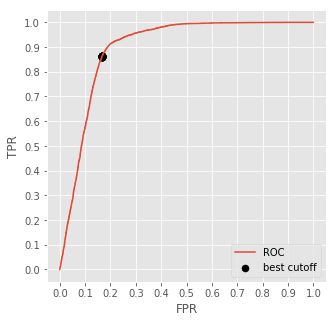

In [30]:

# plot ROC
plt.plot(roc.FPR,roc.TPR,label='ROC')
plt.xlabel("FPR")
plt.ylabel('TPR')

ticks = np.linspace(0,1,11)
plt.yticks(ticks)
plt.xticks(ticks)

# plot best thresholds
best_cutoffs = roc.loc[ (roc.Threshold > 0.43) & (roc.Threshold < 0.44),:]
plt.scatter(best_cutoffs.FPR,best_cutoffs.TPR,c='k',s=50,label='best cutoff')

plt.rc('figure',figsize=(10,5))
plt.legend(loc='best')
plt.show()

In [31]:
Xalltrain = pd.concat([Xtrain,Xvalid],axis = 0)
Yalltrain = pd.concat([Ytrain,Yvalid],axis = 0)
allmatrix = xgb.DMatrix(Xalltrain,Yalltrain)

In [32]:
params

{'colsample_bytree': 0.8,
 'early_stop_rounds': 30,
 'eta': 0.1,
 'eval_metric': 'auc',
 'max_depth': 6,
 'num_rounds': 300,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.8}

In [33]:
n_trees

109

In [34]:
watchlist = [(allmatrix, 'train')]
bst_model = xgb.train(params,allmatrix,n_trees,watchlist)

[0]	train-auc:0.811509
[1]	train-auc:0.887092
[2]	train-auc:0.89533
[3]	train-auc:0.896748
[4]	train-auc:0.897073
[5]	train-auc:0.89673
[6]	train-auc:0.897626
[7]	train-auc:0.898804
[8]	train-auc:0.898892
[9]	train-auc:0.89875
[10]	train-auc:0.898652
[11]	train-auc:0.899246
[12]	train-auc:0.899911
[13]	train-auc:0.900154
[14]	train-auc:0.900233
[15]	train-auc:0.900365
[16]	train-auc:0.900852
[17]	train-auc:0.901051
[18]	train-auc:0.901217
[19]	train-auc:0.901894
[20]	train-auc:0.902131
[21]	train-auc:0.902371
[22]	train-auc:0.902555
[23]	train-auc:0.902855
[24]	train-auc:0.903039
[25]	train-auc:0.903276
[26]	train-auc:0.903437
[27]	train-auc:0.903495
[28]	train-auc:0.903583
[29]	train-auc:0.903907
[30]	train-auc:0.904149
[31]	train-auc:0.904953
[32]	train-auc:0.905124
[33]	train-auc:0.905227
[34]	train-auc:0.905248
[35]	train-auc:0.905386
[36]	train-auc:0.905522
[37]	train-auc:0.905995
[38]	train-auc:0.906303
[39]	train-auc:0.906374
[40]	train-auc:0.906512
[41]	train-auc:0.906827
[42]	

In [36]:
yall_test_predictProbs = bst_model.predict(test_matrix,ntree_limit = n_trees)
yall_test_predict = (yall_test_predictProbs > threshold).astype(int)
print ('accuracy:{}'.format(accuracy_score(Ytest,yall_test_predict)))

accuracy:0.8440487965710518


In [38]:
print (classification_report(Ytest,yall_test_predict))

             precision    recall  f1-score   support

          0       0.94      0.83      0.88     21236
          1       0.69      0.87      0.77      9094

avg / total       0.86      0.84      0.85     30330



Comapre old profit and the profit under the model

In [39]:
loan_test = loan.loc[Ytest.index,:]
old_profit = sum(loan_test['profit'])
old_profit

3921

In [41]:
new_profit = cal_profits(loan_test.repaid,yall_test_predictProbs,threshold)
new_profit

4364

The model improved the profit!

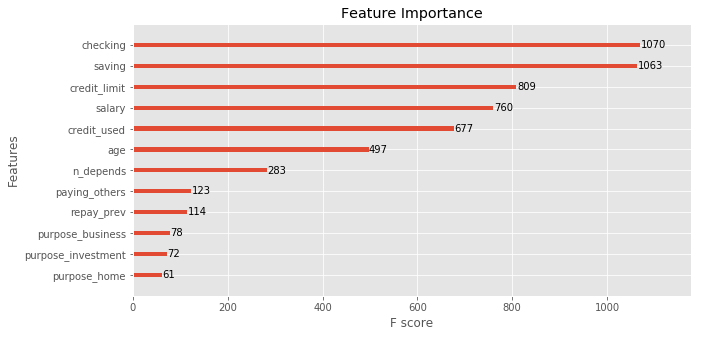

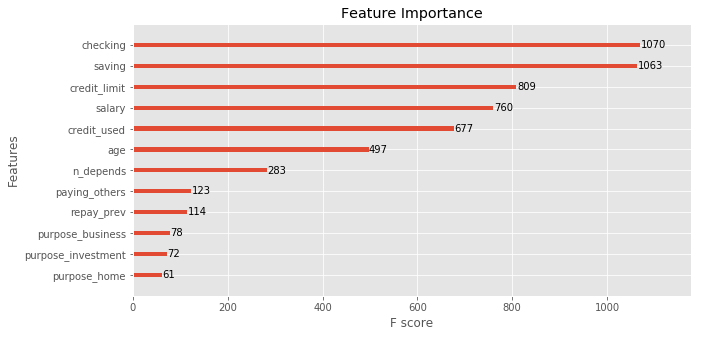

In [43]:
xgb.plot_importance(bst_model,title='Feature Importance')
plt.show()